In [1]:
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

Data source import complete.


In [2]:
# Import các thư viện cần thiết
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import VGG19, ResNet152V2, Xception, DenseNet201
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from keras.layers import BatchNormalization, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')

tf.config.optimizer.set_jit(True)

warnings.filterwarnings("ignore")

2025-08-27 15:02:25.620292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756306945.812682     100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756306945.865375     100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
try:
    # Ưu tiên dùng GPU (L4x4 hoặc A100 trên Kaggle)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()  # Dùng nhiều GPU nếu có
        print(f"Using {len(gpus)} GPU(s)")
    else:
        # Nếu không có GPU thì fallback về CPU
        strategy = tf.distribute.get_strategy()
        print("No GPU found, using CPU")
except:
    strategy = tf.distribute.get_strategy()
    print("Fallback: Using default strategy (CPU)")
    
print("Number of accelerators:", strategy.num_replicas_in_sync)


Using 4 GPU(s)
Number of accelerators: 4


I0000 00:00:1756306958.170163     100 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21087 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
I0000 00:00:1756306958.170762     100 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21087 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9
I0000 00:00:1756306958.171227     100 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21087 MB memory:  -> device: 2, name: NVIDIA L4, pci bus id: 0000:00:05.0, compute capability: 8.9
I0000 00:00:1756306958.171751     100 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21087 MB memory:  -> device: 3, name: NVIDIA L4, pci bus id: 0000:00:06.0, compute capability: 8.9


In [4]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)
# Head 
df_train

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [5]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)
df_test

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [6]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


In [7]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [9]:
# ===== MERGED CELL (FIXED): BiT-M Cluster-Stratified + X-ray Augmentation =====
import os, gc, numpy as np, pandas as pd, tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import ks_2samp

# ---- defaults nếu thiếu ----
IMAGE_SIZE   = globals().get('IMAGE_SIZE', (256, 256))
BATCH_SIZE   = int(globals().get('BATCH_SIZE', 32))
SEED         = int(globals().get('SEED', 42))

np.random.seed(SEED); tf.random.set_seed(SEED)
IMG_H, IMG_W = int(IMAGE_SIZE[0]), int(IMAGE_SIZE[1])
BS = int(BATCH_SIZE)

# ---- 0) quét ảnh từ train và test để kết hợp thành bộ chung ----
def _gather(root):
    items = []
    for dp, _, files in os.walk(root):
        if os.path.basename(dp).startswith('.'):
            continue
        for f in files:
            fl = f.lower()
            if fl.endswith(('.jpg','.jpeg','.png','.bmp','.webp')):
                fp = os.path.join(dp, f)
                label = os.path.basename(os.path.dirname(fp))
                items.append((os.path.abspath(fp), str(label)))
    return items

if 'data_dir' not in globals() or not os.path.isdir(data_dir):
    raise RuntimeError("Thiếu data_dir hoặc không hợp lệ.")
train_items = _gather(data_dir)
test_items = _gather(test_dir) if 'test_dir' in globals() and os.path.isdir(test_dir) else []
all_items = train_items + test_items
if not all_items:
    raise RuntimeError("Không tìm thấy ảnh dưới data_dir hoặc test_dir")
df_train_all = pd.DataFrame(all_items, columns=['filepath','label']).drop_duplicates('filepath').reset_index(drop=True)
df_train_all = df_train_all[df_train_all['label'].isin(['NORMAL', 'PNEUMONIA'])].reset_index(drop=True)  # Lọc nhãn hợp lệ

# ---- 1) trích đặc trưng bằng BiT-M (ResNet50x1 TF-Hub) để CLUSTERING ----
def _load_and_prep(fp):
    img = tf.io.read_file(fp)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.keras.applications.resnet.preprocess_input(tf.cast(img, tf.float32))
    return img

batch_embed = min(64, BS if BS > 0 else 32)
feat_ds = (tf.data.Dataset.from_tensor_slices(df_train_all['filepath'].values)
           .map(_load_and_prep, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_embed)
           .prefetch(tf.data.AUTOTUNE))

import tensorflow_hub as hub
bit_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_model = hub.KerasLayer(bit_url, trainable=False)

emb_list = []
with tf.device('/CPU:0'):
    for batch in feat_ds:
        emb_list.append(bit_model(batch, training=False).numpy())
emb = np.concatenate(emb_list, axis=0)

# ---- 2) PCA + KMeans -> nhãn cụm ----
pca = PCA(n_components=5, random_state=SEED)
Z5 = pca.fit_transform(emb)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=SEED)
clusters = kmeans.fit_predict(Z5)
df_train_all = df_train_all.copy()
df_train_all['cluster'] = clusters

# ---- 3) stratified split 80/10/10 theo cụm và nhãn ----
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
tr_idx, temp_idx = next(sss.split(df_train_all, df_train_all['cluster']))
train_df = df_train_all.iloc[tr_idx].drop(columns=['cluster']).reset_index(drop=True)
temp_df = df_train_all.iloc[temp_idx].drop(columns=['cluster']).reset_index(drop=True)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
va_idx, te_idx = next(sss.split(temp_df, temp_df['label']))
val_df = temp_df.iloc[va_idx].reset_index(drop=True)
test_df = temp_df.iloc[te_idx].reset_index(drop=True)

# Kiểm tra phân bố nhãn
print("Train labels:", train_df['label'].value_counts(normalize=True))
print("Val labels:", val_df['label'].value_counts(normalize=True))
print("Test labels:", test_df['label'].value_counts(normalize=True))

# ---- 4) KS test ----
ks_stats, p_vals = [], []
for j in range(Z5.shape[1]):
    ks, p = ks_2samp(Z5[tr_idx, j], Z5[va_idx, j])
    ks_stats.append(ks); p_vals.append(p)
print(f"[KS] mean KS = {np.mean(ks_stats):.4f} | mean p-value = {np.mean(p_vals):.4f}")
print(f"[Sizes] train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# ---- 5) Augmentation chuyên biệt cho ảnh X-quang (Albumentations) ----
try:
    import albumentations as A
    from albumentations.core.composition import OneOf
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "albumentations", "opencv-python-headless"])
    import albumentations as A
    from albumentations.core.composition import OneOf

import cv2

train_transform = A.Compose([
    A.Rotate(limit=15, border_mode=cv2.BORDER_REPLICATE, p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0,
                       border_mode=cv2.BORDER_REPLICATE, p=0.8),
    A.Affine(shear=0.1, p=0.5),
    A.HorizontalFlip(p=0.5),
    OneOf([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ], p=0.8),
    OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.GaussNoise(var_limit=(5, 20), p=0.5),
        A.MedianBlur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.Resize(IMG_H, IMG_W),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])

val_test_transform = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])

# ---- 6) Generator tương thích Keras: có .classes & .class_indices ----
class AlbumentationsGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, transform, class_names=None, batch_size=32, shuffle=True):
        self.df = df.reset_index(drop=True)
        if class_names is None:
            class_names = sorted(self.df['label'].astype(str).unique().tolist())
        self.class_names = list(class_names)
        self.class_indices = {c:i for i,c in enumerate(self.class_names)}
        self.classes = self.df['label'].astype(str).map(self.class_indices).values.astype(int)
        self.transform = transform
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    def __getitem__(self, index):
        idx = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        imgs, labels = [], []
        for i in idx:
            row = self.df.iloc[i]
            img = cv2.imread(row['filepath'])
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            aug = self.transform(image=img)
            img = aug['image'].astype(np.float32)
            imgs.append(img)
            labels.append(self.class_indices[str(row['label'])])
        if len(imgs) == 0:
            return np.zeros((0, IMG_H, IMG_W, 3), dtype=np.float32), np.zeros((0,), dtype=np.int32)
        return np.stack(imgs, axis=0), np.array(labels)
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# đồng bộ class_names giữa train/val/(test)
_all_names = pd.concat([
    train_df['label'].astype(str),
    val_df['label'].astype(str),
    test_df['label'].astype(str) if test_df is not None else pd.Series(dtype=str)
]).unique().tolist()
class_names = sorted(_all_names)

train_ds = AlbumentationsGenerator(train_df, train_transform, class_names=class_names, batch_size=BS, shuffle=True)
validation_ds = AlbumentationsGenerator(val_df, val_test_transform, class_names=class_names, batch_size=BS, shuffle=False)
test_ds = AlbumentationsGenerator(test_df, val_test_transform, class_names=class_names, batch_size=BS, shuffle=False) if test_df is not None else None

# alias để giữ tương thích
train_datagen = train_ds
validation_datagen = validation_ds
test_datagen = test_ds

# ---- 7) Nếu pipeline sau cần numpy arrays ----
def _to_numpy(seq):
    Xs, Ys = [], []
    for b in range(len(seq)):
        x, y = seq[b]
        if x.shape[0] == 0:  # batch rỗng
            continue
        Xs.append(x); Ys.append(y)
    if len(Xs) == 0:
        return np.zeros((0, IMG_H, IMG_W, 3), dtype=np.float32), np.zeros((0,), dtype=np.int32)
    return np.concatenate(Xs, axis=0), np.concatenate(Ys, axis=0)

x_train, y_train = _to_numpy(train_ds)
x_val,   y_val   = _to_numpy(validation_ds)
if test_ds is not None:
    x_test,  y_test  = _to_numpy(test_ds)
else:
    x_test = np.zeros((0, IMG_H, IMG_W, 3), dtype=np.float32)
    y_test = np.zeros((0,), dtype=np.int32)

x_train = x_train.astype(np.float32)  # Sửa thành float32
x_val   = x_val.astype(np.float32)
if x_test.size:
    x_test = x_test.astype(np.float32)

print('x_train:', x_train.shape, '| y_train:', y_train.shape)
print('x_val  :', x_val.shape,   '| y_val  :', y_val.shape)
print('x_test :', x_test.shape,  '| y_test :', y_test.shape)

gc.collect()
# ================== END MERGED CELL ==================

Train labels: label
PNEUMONIA    0.729666
NORMAL       0.270334
Name: proportion, dtype: float64
Val labels: label
PNEUMONIA    0.732877
NORMAL       0.267123
Name: proportion, dtype: float64
Test labels: label
PNEUMONIA    0.732877
NORMAL       0.267123
Name: proportion, dtype: float64
[KS] mean KS = 0.0928 | mean p-value = 0.1127
[Sizes] train=4672, val=584, test=584
x_train: (4672, 256, 256, 3) | y_train: (4672,)
x_val  : (584, 256, 256, 3) | y_val  : (584,)
x_test : (584, 256, 256, 3) | y_test : (584,)


193

## **Phân tích Phân phối Nhãn**

## **Visualize images**

In [10]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

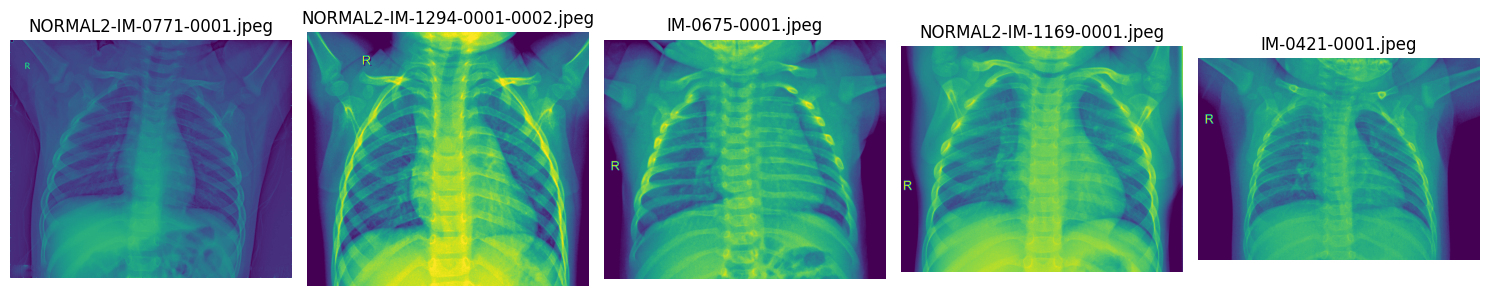

In [11]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

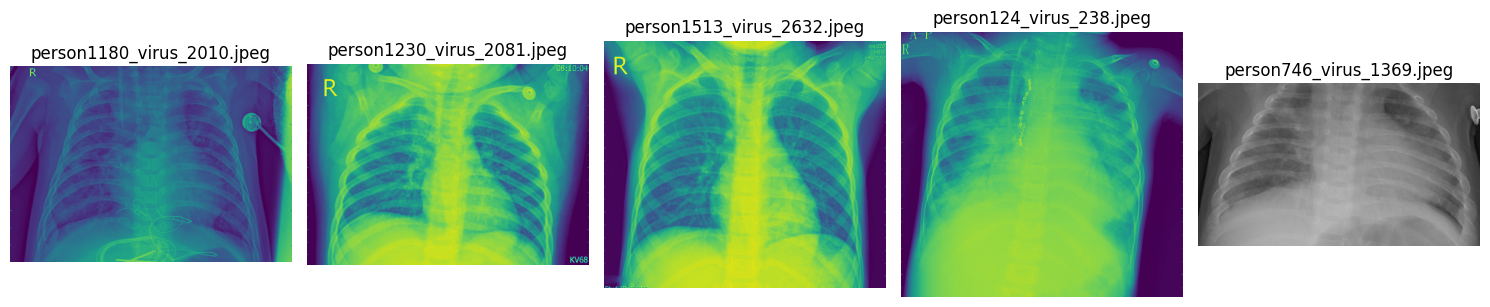

In [12]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [13]:
from keras.layers import BatchNormalization, GlobalAveragePooling2D,Conv2D, MaxPooling2D

In [14]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Chuyển class_weights sang dạng dictionary
class_weight_dict = dict(enumerate(class_weights))

print('Class weights:', class_weight_dict)

Class weights: {0: 1.8495645288994458, 1: 0.6852449398650631}


In [15]:
LEARNING_RATE =0.0001

In [16]:
# ===== METRICS (cho bài nhị phân) =====
import tensorflow as tf
METRICS_BIN = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc', curve='ROC'),
    tf.keras.metrics.AUC(name='auprc', curve='PR'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.SensitivityAtSpecificity(0.95, name='sens_at_spec95'),
    tf.keras.metrics.SpecificityAtSensitivity(0.95, name='spec_at_sens95'),
]


# **DenseNet201**

In [17]:
with strategy.scope():
    def build_DenseNet201(input_shape=(256, 256, 3)):
        # Initialize DenseNet201 base model
        base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

        # Use the DenseNet201 model for feature extraction
        x = base_model.output
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # Flatten the output of the base model
        x = GlobalAveragePooling2D()(x)
        # Add custom fully connected layers
        x = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)

        # Output layer for binary classification
        predictions = Dense(1, activation='sigmoid')(x)

        # Define the full model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Freeze the layers of the base model to prevent them from training
        for layer in base_model.layers[-10:]:
            layer.trainable = True

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss=BinaryCrossentropy(),
                      metrics=METRICS_BIN)

        return model

    # Create the DenseNet201 model
    DenseNet201_model = build_DenseNet201(input_shape=(256, 256, 3))

    # Callbacks for DenseNet201
    early_stopping_DenseNet201 = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True)
    model_checkpoint_DenseNet201 = ModelCheckpoint('DenseNet201_best_model.keras', save_best_only=True, monitor='val_auc')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # Train the DenseNet201 model
    history_DenseNet201 = DenseNet201_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_DenseNet201, reduce_lr,early_stopping_DenseNet201],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=0
    )

    # ===== PATCH: EVALUATE DenseNet201 (fix too many values to unpack) =====
    try:
        res = DenseNet201_model.evaluate(x_test, y_test, verbose=1, return_dict=True)
    except TypeError:
        _vals = DenseNet201_model.evaluate(x_test, y_test, verbose=1)
        res = dict(zip(DenseNet201_model.metrics_names, _vals))
    
    loss_DenseNet201     = float(res['loss'])
    accuracy_DenseNet201 = float(res.get('accuracy', res.get('acc')))
    print("DenseNet201:", res)
    print(f"Test Loss DenseNet201: {loss_DenseNet201}")
    print(f"Test Accuracy DenseNet201: {accuracy_DenseNet201}")


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


I0000 00:00:1756307763.370610     349 service.cc:148] XLA service 0x7c0bf4007c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756307763.371466     349 service.cc:156]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756307763.371482     349 service.cc:156]   StreamExecutor device (1): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756307763.371484     349 service.cc:156]   StreamExecutor device (2): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756307763.371487     349 service.cc:156]   StreamExecutor device (3): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756307767.133057     349 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756307767.410975     346 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756307767.768681     353 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756307768.048130     344 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-27 15:19:32.032921: E exter

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9616 - auc: 0.9686 - auprc: 0.9734 - loss: 0.2130 - precision: 0.9632 - recall: 0.9856 - sens_at_spec95: 0.9152 - spec_at_sens95: 0.9550
DenseNet201: {'accuracy': 0.9691780805587769, 'auc': 0.984775722026825, 'auprc': 0.9886011481285095, 'loss': 0.2097645401954651, 'precision': 0.9745370149612427, 'recall': 0.9836448431015015, 'sens_at_spec95': 0.9719626307487488, 'spec_at_sens95': 0.9679487347602844}
Test Loss DenseNet201: 0.2097645401954651
Test Accuracy DenseNet201: 0.9691780805587769


# **VGG19**

In [18]:
with strategy.scope():
    def build_vgg19(input_shape=(256, 256, 3)):
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
        x = base_model.output
        # Flatten the output of the base model
        x = GlobalAveragePooling2D()(x)
        
        # Fully connected layers with Batch Normalization and L2 Regularization
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
        x = BatchNormalization()(x)  # Batch Normalization after Dense
        x = Dropout(0.1)(x)
        
        # Output layer
        predictions = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        # Fine-tune the last 3 layers
        for layer in base_model.layers[-3:]:
            layer.trainable = True

        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss=BinaryCrossentropy(),
                      metrics=METRICS_BIN
)
        return model

    # Tạo mô hình VGG19
    vgg19_model = build_vgg19(input_shape=(256, 256, 3))

    # Callbacks cho VGG19
    early_stopping_vgg19 = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True)
    model_checkpoint_vgg19 = ModelCheckpoint('vgg19_best_model.keras', save_best_only=True, monitor='val_auc')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Huấn luyện mô hình VGG19
    history_vgg19 = vgg19_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_vgg19, reduce_lr, early_stopping_vgg19],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=0
    )

    # ===== PATCH: EVALUATE VGG19 (fix too many values to unpack) =====
    try:
        res = vgg19_model.evaluate(x_test, y_test, verbose=1, return_dict=True)
    except TypeError:
        _vals = vgg19_model.evaluate(x_test, y_test, verbose=1)
        res = dict(zip(vgg19_model.metrics_names, _vals))
    
    loss_vgg19     = float(res['loss'])
    accuracy_vgg19 = float(res.get('accuracy', res.get('acc')))
    print("VGG19:", res)
    print(f"Test Loss VGG19: {loss_vgg19}")
    print(f"Test Accuracy VGG19: {accuracy_vgg19}")



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9618 - auc: 0.9788 - auprc: 0.9881 - loss: 0.3802 - precision: 0.9862 - recall: 0.9611 - sens_at_spec95: 0.9096 - spec_at_sens95: 0.9597
VGG19: {'accuracy': 0.9708904027938843, 'auc': 0.9893288016319275, 'auprc': 0.9949246644973755, 'loss': 0.3737439513206482, 'precision': 0.9928057789802551, 'recall': 0.9672897458076477, 'sens_at_spec95': 0.9789719581604004, 'spec_at_sens95': 0.9807692170143127}
Test Loss VGG19: 0.3737439513206482
Test Accuracy VGG19: 0.9708904027938843


# **ResNet152V2**

In [19]:
with strategy.scope():
    def build_resnet152v2(input_shape=(256, 256, 3)):
        # Initialize ResNet152V2 base model
        base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=input_shape)
        
        # Extract features with base model
        x = base_model.output
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = GlobalAveragePooling2D()(x)
        
        # Add custom fully connected layers
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        # Output layer for binary classification
        predictions = Dense(1, activation='sigmoid')(x)
        
        # Define the full model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Freeze the layers of the base model to prevent them from training
        for layer in base_model.layers[-30:]:
            layer.trainable = True

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss=BinaryCrossentropy(),
                      metrics=METRICS_BIN)
        
        return model
    
    # Create the ResNet152V2 model
    resnet152v2_model = build_resnet152v2(input_shape=(256, 256, 3))
    
    # Callbacks for ResNet152V2
    early_stopping_ResNet152V2 = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True)
    model_checkpoint_resnet152v2 = ModelCheckpoint('resnet152v2_best_model.keras', save_best_only=True, monitor='val_auc')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # Train the ResNet152V2 model
    history_resnet152v2 = resnet152v2_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_resnet152v2, reduce_lr, early_stopping_ResNet152V2],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=0
        
    )
    
    # ===== PATCH: EVALUATE ResNet152V2 (fix too many values to unpack) =====
    try:
        res = resnet152v2_model.evaluate(x_test, y_test, verbose=1, return_dict=True)
    except TypeError:
        _vals = resnet152v2_model.evaluate(x_test, y_test, verbose=1)
        res = dict(zip(resnet152v2_model.metrics_names, _vals))
    
    loss_resnet152v2     = float(res['loss'])
    accuracy_resnet152v2 = float(res.get('accuracy', res.get('acc')))
    print("ResNet152V2:", res)
    print(f"Test Loss ResNet152V2: {loss_resnet152v2}")
    print(f"Test Accuracy ResNet152V2: {accuracy_resnet152v2}")
                        

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9715 - auc: 0.9940 - auprc: 0.9980 - loss: 0.1162 - precision: 0.9745 - recall: 0.9869 - sens_at_spec95: 0.9635 - spec_at_sens95: 0.9534
ResNet152V2: {'accuracy': 0.965753436088562, 'auc': 0.9937695264816284, 'auprc': 0.9978060126304626, 'loss': 0.11553937941789627, 'precision': 0.9722222089767456, 'recall': 0.9813084006309509, 'sens_at_spec95': 0.9672897458076477, 'spec_at_sens95': 0.9679487347602844}
Test Loss ResNet152V2: 0.11553937941789627
Test Accuracy ResNet152V2: 0.965753436088562


# **Xception**

In [20]:
with strategy.scope():
    def build_xception(input_shape=(256, 256, 3)):
        base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
        x = base_model.output
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(x)
        x = BatchNormalization()(x)  # Batch Normalization after Dense
        x = Dropout(0.1)(x)
        predictions = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        for layer in base_model.layers[-50:]:
            layer.trainable = True
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss=BinaryCrossentropy(),
                      metrics=METRICS_BIN)
        return model

    # Tạo mô hình
    xception_model = build_xception(input_shape=(256, 256, 3))
    
    # Callbacks
    early_stopping_Xception = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True)
    model_checkpoint_xception = ModelCheckpoint('xception_best_model.keras', save_best_only=True, monitor='val_auc')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # Huấn luyện mô hình
    history_xception = xception_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_xception, reduce_lr, early_stopping_Xception],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=0
    )
    
    # ===== PATCH: EVALUATE Xception (fix too many values to unpack) =====
    try:
        res = xception_model.evaluate(x_test, y_test, verbose=1, return_dict=True)
    except TypeError:
        _vals = xception_model.evaluate(x_test, y_test, verbose=1)
        res = dict(zip(xception_model.metrics_names, _vals))
    
    loss_xception     = float(res['loss'])
    accuracy_xception = float(res.get('accuracy', res.get('acc')))
    print("Xception:", res)
    print(f"Test Loss Xception: {loss_xception}")
    print(f"Test Accuracy Xception: {accuracy_xception}")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


E0000 00:00:1756311204.993303     356 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756311204.996029     351 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756311205.094912     346 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756311205.105092     356 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756311205.203977     338 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9405 - auc: 0.9767 - auprc: 0.9901 - loss: 0.3111 - precision: 0.9809 - recall: 0.9362 - sens_at_spec95: 0.9085 - spec_at_sens95: 0.9459
Xception: {'accuracy': 0.9520547986030579, 'auc': 0.9869623184204102, 'auprc': 0.9948962926864624, 'loss': 0.3080848455429077, 'precision': 0.9854369163513184, 'recall': 0.9485981464385986, 'sens_at_spec95': 0.9649532437324524, 'spec_at_sens95': 0.9615384340286255}
Test Loss Xception: 0.3080848455429077
Test Accuracy Xception: 0.9520547986030579


# **Val loss and accuracy**

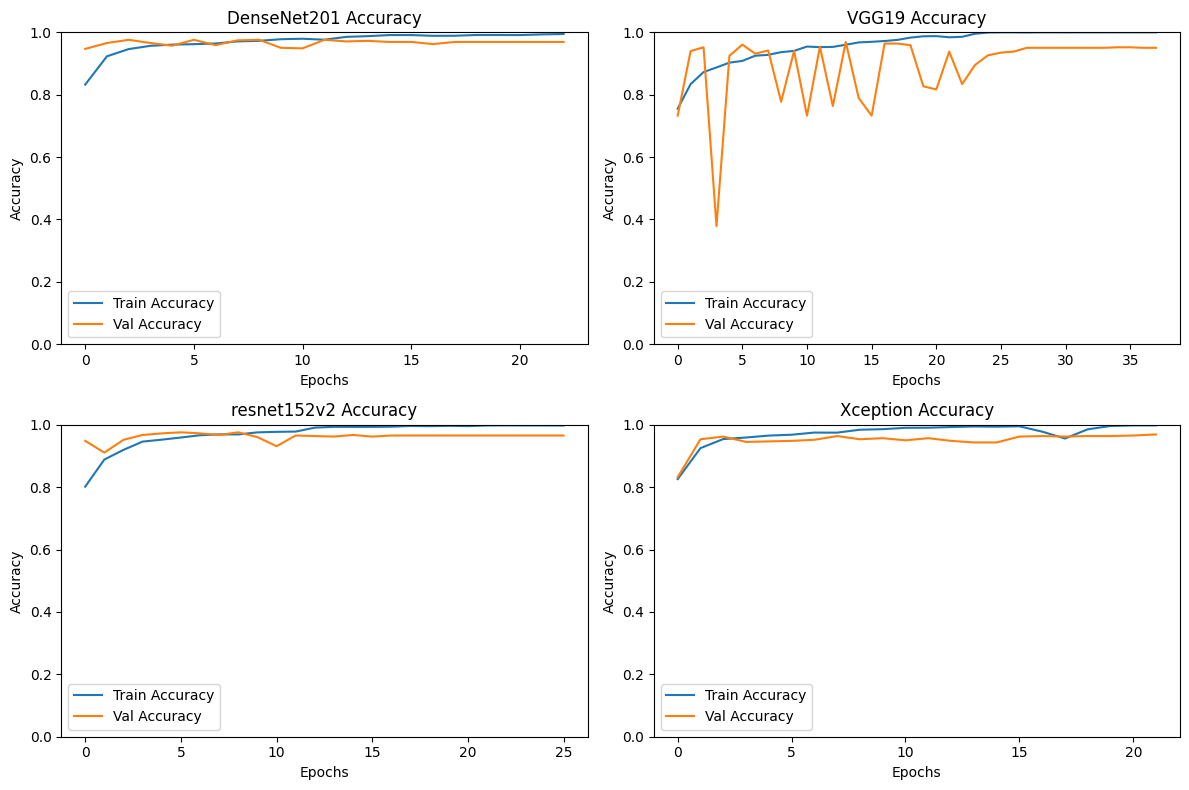

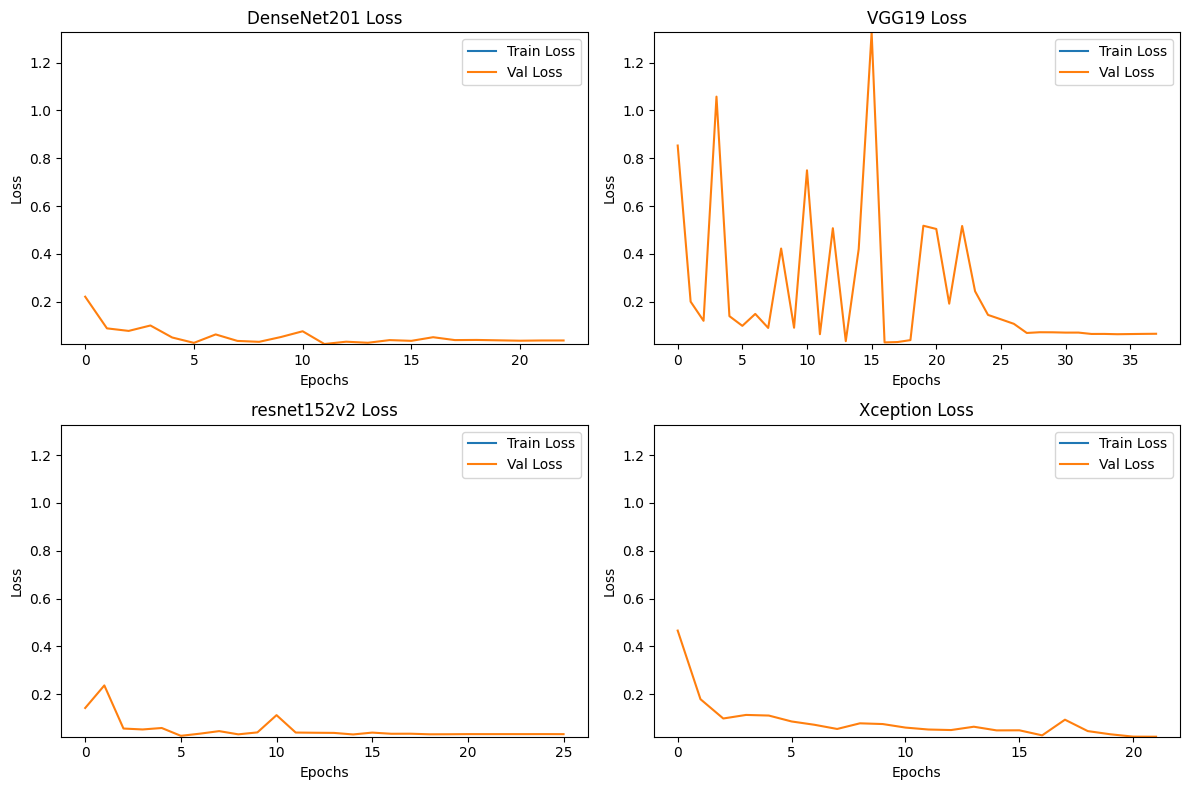

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(histories, model_names):
    # ---- Vẽ biểu đồ Accuracy ----
    # Với accuracy thường nằm trong khoảng [0, 1], nên có thể cố định:
    acc_ylim = (0, 1)
    
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], color='tab:orange', label='Val Accuracy')
        plt.title(f'{model_names[i]} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(acc_ylim)  # Set giới hạn của trục y
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    # ---- Vẽ biểu đồ Loss ----
    # Tính toán giá trị min và max loss trên tất cả các model
    min_loss = float('inf')
    max_loss = float('-inf')
    for history in histories:
        train_loss = np.array(history.history['loss'])
        val_loss = np.array(history.history['val_loss'])
        min_loss = min(min_loss, train_loss.min(), val_loss.min())
        max_loss = max(max_loss, train_loss.max(), val_loss.max())
    
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history['loss'], color='tab:blue', label='Train Loss')
        plt.plot(history.history['val_loss'], color='tab:orange', label='Val Loss')
        plt.title(f'{model_names[i]} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim(min_loss, max_loss)  # Set giới hạn của trục y cho loss
        plt.legend()
    plt.tight_layout()
    plt.show()

# Giả sử bạn đã có các history: history_DenseNet201, history_vgg19, history_resnet152v2, history_xception
histories = [history_DenseNet201, history_vgg19, history_resnet152v2, history_xception]
model_names = ['DenseNet201', 'VGG19', 'resnet152v2', 'Xception']

plot_training_history(histories, model_names)


# **Ensemble Learning (Meta-model Building)**

In [22]:
with strategy.scope():
    import tensorflow as tf
    from tensorflow.keras import layers, Model
    from tensorflow.keras.losses import BinaryCrossentropy
    from tensorflow.keras.metrics import AUC
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

    # ==== Capsule Routing (Sabour et al., 2017) – tối giản cho ensembling ====
    class CapsuleRouting(layers.Layer):
        def __init__(self, num_capsules=2, dim_capsules=16, routings=3, **kwargs):
            super().__init__(**kwargs)
            self.num_capsules = num_capsules
            self.dim_capsules = dim_capsules
            self.routings = routings

        def build(self, input_shape):
            self.num_in = int(input_shape[1])
            self.dim_in = int(input_shape[2])
            self.W = self.add_weight(
                shape=(self.num_in, self.num_capsules, self.dim_in, self.dim_capsules),
                initializer="glorot_uniform",
                trainable=True,
                name="W_caps"
            )
            super().build(input_shape)

        @staticmethod
        def squash(s, axis=-1, eps=1e-7):
            s_norm_sq = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
            s_norm = tf.sqrt(s_norm_sq + eps)
            return (s_norm_sq / (1.0 + s_norm_sq)) * (s / (s_norm + eps))

        def call(self, inputs):
            u_hat = tf.einsum('bin,iond->biod', inputs, self.W)
            b = tf.zeros((tf.shape(inputs)[0], self.num_in, self.num_capsules), dtype=inputs.dtype)
            for r in range(self.routings):
                c = tf.nn.softmax(b, axis=-1)
                c_exp = tf.expand_dims(c, -1)
                s = tf.reduce_sum(c_exp * u_hat, axis=1)
                v = self.squash(s)
                if r < self.routings - 1:
                    v_exp = tf.expand_dims(v, 1)
                    a = tf.reduce_sum(u_hat * v_exp, axis=-1)
                    b = b + a
            return v

    # ==== Ensemble builder: đóng băng 4 model, routing bằng capsule ====
    def build_capsule_ensemble(input_shape=(256, 256, 3), proj_dim=16, routings=3):
        inp = layers.Input(shape=input_shape, name="ens_input")

        # Đóng băng và gọi 4 model ở chế độ inference (BN không cập nhật)
        for m in [vgg19_model, DenseNet201_model, resnet152v2_model, xception_model]:
            m.trainable = False

        # Lấy xác suất từ từng model, chặn gradient và ép float32 cho ổn định số
        def fwd(m, x):
            p = m(x, training=False)                          # (B,1), sigmoid
            p = layers.Lambda(lambda t: tf.stop_gradient(t), name=f"sg_{m.name}")(p)
            return layers.Activation('linear', dtype='float32', name=f"cast_{m.name}")(p)

        # 4 nhánh base models (tất cả nhận 256x256)
        p_vgg = fwd(vgg19_model,       inp)
        p_den = fwd(DenseNet201_model, inp)
        p_res = fwd(resnet152v2_model, inp)
        p_xcp = fwd(xception_model,    inp)

        # Ghép xác suất thành vector (B,4)
        probs = layers.Concatenate(name="stack_probs", dtype='float32')([p_vgg, p_den, p_res, p_xcp])

        # Đưa về logits ổn định: log(p/(1-p)) với clipping
        def to_logit(t):
            t = tf.clip_by_value(t, 1e-6, 1. - 1e-6)
            return tf.math.log(t / (1. - t))
        logits = layers.Lambda(to_logit, name="to_logits", dtype='float32')(probs)

        # Primary capsules: 4 capsules, mỗi capsule từ 1D → proj_dim bằng Conv1D(kernel=1)
        x = layers.Reshape((4, 1), name="as_caps")(logits)               # (B,4,1)
        x = layers.Conv1D(proj_dim, kernel_size=1, activation="linear",
                          name="caps_primary")(x)                         # (B,4,proj_dim)

        # Dynamic routing tới 2 class capsules
        caps = CapsuleRouting(num_capsules=2, dim_capsules=proj_dim, routings=routings,
                              name="caps_routing")(x)                     # (B,2,proj_dim)

        # Độ dài capsule = mức độ hiện diện lớp; softmax theo lớp → lấy xác suất lớp dương
        lengths = layers.Lambda(lambda t: tf.norm(t, axis=-1), name="caps_lengths")(caps)  # (B,2)
        p_pos = layers.Lambda(lambda t: tf.nn.softmax(t, axis=-1)[..., 1:2],
                              name="positive_prob", dtype='float32')(lengths)              # (B,1)

        model = Model(inputs=inp, outputs=p_pos, name="CapsuleEnsemble4")

        # Giữ đúng optimizer/loss/metrics bạn đang dùng
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss=BinaryCrossentropy(),
            metrics=['accuracy', AUC(name='auc')]
        )
        return model

    # Tạo & train ensemble — chuyển input_shape sang 256x256
    capsule_ensemble_model = build_capsule_ensemble(input_shape=(256, 256, 3), proj_dim=16, routings=3)

    early_stopping_caps = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    model_checkpoint_caps = ModelCheckpoint('capsule_ensemble_best_model.keras', save_best_only=True, monitor='val_accuracy')
    reduce_lr_caps = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history_capsule_ensemble = capsule_ensemble_model.fit(
        x_train, y_train.astype('float32'),
        epochs=70,
        validation_data=(x_val, y_val.astype('float32')),
        callbacks=[model_checkpoint_caps, reduce_lr_caps, early_stopping_caps],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=0
    )

    results = capsule_ensemble_model.evaluate(x_test, y_test.astype('float32'), verbose=0, return_dict=True)
    print(f"CapsEnsemble - Test Loss: {results.get('loss')}")
    print(f"CapsEnsemble - Test Accuracy: {results.get('accuracy')}")
    print(f"CapsEnsemble - Test AUC: {results.get('auc')}")


Epoch 1/70
146/146 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: nan - auc: nan - loss: nan - val_accuracy: 0.2028 - val_auc: 0.3773 - val_loss: 0.7039 - learning_rate: 1.0000e-04
Epoch 2/70
146/146 ━━━━━━━━━━━━━━━━━━━━ 53s 361ms/step - accuracy: nan - auc: nan - loss: nan - val_accuracy: 0.2205 - val_auc: 0.7152 - val_loss: 0.6979 - learning_rate: 1.0000e-04
Epoch 3/70
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 224ms/step - accuracy: nan - auc: nan - loss: nan - val_accuracy: 0.3484 - val_auc: 0.8615 - val_loss: 0.6888 - learning_rate: 1.0000e-04
Epoch 4/70
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: nan - auc: nan - loss: nan - val_accuracy: 0.4589 - val_auc: 0.9741 - val_loss: 0.6728 - learning_rate: 1.0000e-04
Epoch 5/70
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 226ms/step - accuracy: nan - auc: nan - loss: nan - val_accuracy: 0.6366 - val_auc: 0.9991 - val_loss: 0.6159 - learning_rate: 1.0000e-04
Epoch 6/70
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: nan - auc: nan - loss: na

In [32]:
# Đánh giá (dùng dict để tránh lỗi unpack)
results = capsule_ensemble_model.evaluate(x_test, y_test, verbose=0, return_dict=True)
print(f"CapsEnsemble - Test Loss: {results.get('loss')}")
print(f"CapsEnsemble - Test Accuracy: {results.get('accuracy')}")
print(f"CapsEnsemble - Test AUC: {results.get('auc')}")

# Nếu muốn xem đầy đủ tên metric đang trả về:
# print("metrics_names:", capsule_ensemble_model.metrics_names)


CapsEnsemble - Test Loss: 0.36382022500038147
CapsEnsemble - Test Accuracy: 0.969138503074646
CapsEnsemble - Test AUC: 0.9511284232139587


===== DenseNet201 =====
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       156
   Pneumonia       0.97      0.98      0.98       428

    accuracy                           0.97       584
   macro avg       0.96      0.96      0.96       584
weighted avg       0.97      0.97      0.97       584



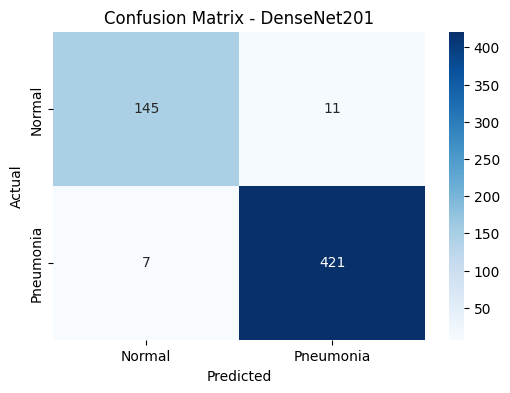

===== VGG19 =====
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95       156
   Pneumonia       0.99      0.97      0.98       428

    accuracy                           0.97       584
   macro avg       0.95      0.97      0.96       584
weighted avg       0.97      0.97      0.97       584



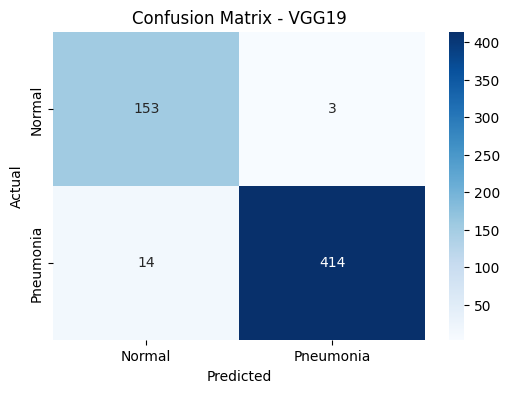

===== ResNet152V2 =====
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.92      0.94       156
   Pneumonia       0.97      0.98      0.98       428

    accuracy                           0.97       584
   macro avg       0.96      0.95      0.96       584
weighted avg       0.97      0.97      0.97       584



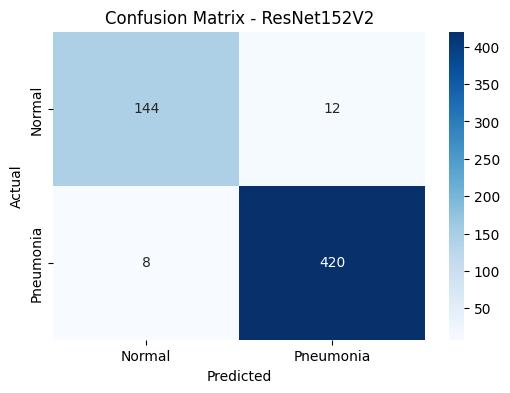

===== Xception =====
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.96      0.91       156
   Pneumonia       0.99      0.95      0.97       428

    accuracy                           0.95       584
   macro avg       0.93      0.96      0.94       584
weighted avg       0.96      0.95      0.95       584



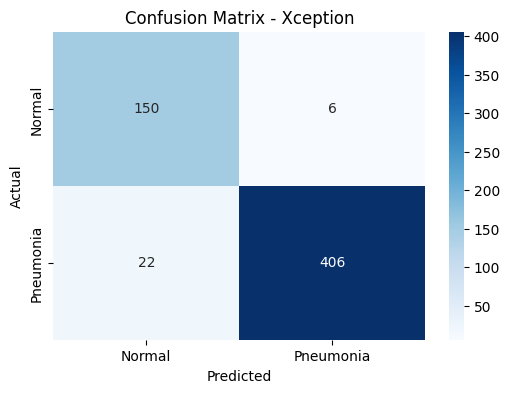

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa tên các lớp (phù hợp với bài toán phân loại nhị phân)
class_names = ['Normal', 'Pneumonia']  # Thay thế bằng tên lớp thực tế của bạn

# Danh sách các model
models = [DenseNet201_model, vgg19_model, resnet152v2_model, xception_model]
model_names = ['DenseNet201', 'VGG19', 'ResNet152V2', 'Xception']

# Lặp qua từng model để vẽ Classification Report và Confusion Matrix
for model, name in zip(models, model_names):
    print(f"===== {name} =====")
    
    # Dự đoán trên tập test
    y_pred = model.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Chuyển đổi dự đoán từ xác suất sang lớp (0 hoặc 1)
    y_true = y_test  # Nhãn thực tế đã ở dạng lớp (0 hoặc 1)

    # 1. Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # 2. Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Vẽ Confusion Matrix bằng Seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [37]:
# ==== DROP-IN: robust predict + report for ensemble_model (binary) ====
import numpy as np, tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Resolve strategy / batch size (fallbacks an toàn) ----
BATCH_SIZE = globals().get('BATCH_SIZE', 32)
strategy = globals().get('strategy', None)
num_replicas = getattr(strategy, 'num_replicas_in_sync', 1) if strategy is not None else 1
GLOBAL_BATCH = BATCH_SIZE * num_replicas

# ---- 1) Build test_dataset từ nhiều nguồn khác nhau ----
def _from_directory_iterator(di):
    """Keras DirectoryIterator -> tf.data (giữ preprocessing của iterator)"""
    img_shape = tuple(di.image_shape)
    def gen_images():
        for i in range(len(di)):   # iterate batches
            bx, _ = di[i]
            for j in range(bx.shape[0]):
                yield bx[j]
    ds = tf.data.Dataset.from_generator(
        gen_images,
        output_signature=tf.TensorSpec(shape=img_shape, dtype=tf.float32)
    )
    return ds.batch(GLOBAL_BATCH).prefetch(tf.data.AUTOTUNE)

def build_test_dataset():
    # test_stack: numpy [N,H,W,C]
    if 'test_stack' in globals():
        x = np.asarray(globals()['test_stack'])
        return tf.data.Dataset.from_tensor_slices(x).batch(GLOBAL_BATCH).prefetch(tf.data.AUTOTUNE)
    # X_test: numpy [N,H,W,C]
    if 'X_test' in globals():
        x = np.asarray(globals()['X_test'])
        return tf.data.Dataset.from_tensor_slices(x).batch(GLOBAL_BATCH).prefetch(tf.data.AUTOTUNE)
    # test_ds: tf.data hoặc DirectoryIterator
    if 'test_ds' in globals():
        ds = globals()['test_ds']
        if isinstance(ds, tf.data.Dataset):
            spec = ds.element_spec
            # Nếu là (x,y) -> bỏ y để predict
            if isinstance(spec, tuple) and len(spec) == 2:
                ds_x = ds.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE)
            else:
                ds_x = ds
            return ds_x.batch(GLOBAL_BATCH).prefetch(tf.data.AUTOTUNE)
        else:
            # Keras DirectoryIterator
            return _from_directory_iterator(ds)
    raise RuntimeError("Không tìm thấy dữ liệu test: cung cấp `test_stack` hoặc `X_test` hoặc `test_ds`.")

test_dataset = build_test_dataset()

# ---- 2) Lấy y_true (nếu có) từ nhiều nguồn ----
def extract_y_true():
    # y_test (numpy / list)
    if 'y_test' in globals():
        y = globals()['y_test']
        y = np.asarray(y).squeeze()
        # Nếu one-hot -> lấy cột lớp Positive (giả định nhãn 0/1)
        if y.ndim == 2 and y.shape[1] >= 2:
            y = np.argmax(y, axis=1)
        return y.astype(int)
    # y_test_int có sẵn
    if 'y_test_int' in globals():
        return np.asarray(globals()['y_test_int']).astype(int)

    # test_ds: cố gắng suy label
    if 'test_ds' in globals():
        ds = globals()['test_ds']
        # 2a) DirectoryIterator có .classes
        classes = getattr(ds, 'classes', None)
        if classes is not None:
            return np.asarray(classes).astype(int)
        # 2b) tf.data yields (x,y) -> collect y
        if isinstance(ds, tf.data.Dataset):
            specs = ds.element_spec
            if isinstance(specs, tuple) and len(specs) == 2:
                ys = []
                for _, yb in ds:
                    ys.append(np.asarray(yb))
                if ys:
                    y = np.concatenate(ys, axis=0)
                    if y.ndim == 2 and y.shape[1] >= 2:
                        y = np.argmax(y, axis=1)
                    else:
                        y = y.squeeze()
                    return y.astype(int)

    # Không có y_true -> trả None (chỉ predict, không report)
    return None

y_true = extract_y_true()

# ---- 3) Predict với ensemble_model ----
if 'ensemble_model' not in globals():
    raise RuntimeError("Không tìm thấy `ensemble_model`. Hãy đảm bảo model đã được build/load.")

# Không cần strategy.scope() khi chỉ predict (an toàn giữ nguyên nếu bạn đang dùng MirroredStrategy)
_ctx = strategy.scope() if strategy is not None else None
if _ctx:
    with _ctx:
        y_pred_probs = ensemble_model.predict(test_dataset, verbose=1)
else:
    y_pred_probs = ensemble_model.predict(test_dataset, verbose=1)

# Chuẩn hoá xác suất Positive cho các dạng output khác nhau:
#   - [N, 1] -> ravel
#   - [N, 2] -> lấy cột 1 (Positive)
#   - [N]    -> dùng trực tiếp
ypp = np.asarray(y_pred_probs)
if ypp.ndim == 2 and ypp.shape[1] == 2:
    y_prob_pos = ypp[:, 1]
else:
    y_prob_pos = ypp.ravel()
y_pred = (y_prob_pos >= 0.5).astype(int)

print("=" * 60)
print("Predicted positives:", int(y_pred.sum()), "/", len(y_pred))
print("=" * 60)

# ---- 4) Classification Report & Confusion Matrix (nếu có y_true) ----
if y_true is not None:
    # Cắt/khớp chiều dài nếu lệch do batch cuối
    n = min(len(y_true), len(y_pred))
    y_true = np.asarray(y_true[:n]).astype(int)
    y_pred = np.asarray(y_pred[:n]).astype(int)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Ensemble Model Confusion Matrix', fontsize=14, pad=20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
else:
    print("⚠️ Không tìm thấy y_true -> chỉ hiển thị dự đoán. Cung cấp `y_test`/labels nếu muốn in report & confusion matrix.")
# ==== END DROP-IN ====


AttributeError: 'AlbumentationsGenerator' object has no attribute 'image_shape'

In [23]:
!tar -czvf working_dir_2label.tar.gz /kaggle/working


tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/vgg19_best_model.keras
/kaggle/working/capsule_ensemble_best_model.keras
/kaggle/working/resnet152v2_best_model.keras
/kaggle/working/xception_best_model.keras
/kaggle/working/working_dir_2label.tar.gz
tar: /kaggle/working/working_dir_2label.tar.gz: file changed as we read it
/kaggle/working/DenseNet201_best_model.keras
/kaggle/working/.virtual_documents/


In [24]:
from IPython.display import FileLink
FileLink("working_dir_2label.tar.gz")


/kaggle/working/working_dir_2label.tar.gz